# Model comparison

## 0. Libraries import

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#utils
import pandas as pd
import re 
import copy
from datetime import datetime
from costum_utils import glasgow_maker

#data pre processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

#classifier RFECV
from sklearn.ensemble import RandomForestClassifier

#feature selection
from sklearn.feature_selection import RFECV

#hyperopt
from hyperopt import hp
from hyperopt import fmin, tpe, Trials

#best model
from pipelines import BestModel_with_bagging,optim_pipeline

#confusion matrix
from sklearn.metrics import confusion_matrix

#visualize perfomance
#from costum_utils import perfomance_visualizer

from hyperopt.pyll import scope
@scope.define
def intero(a):
     return int(a)

## 1.Dataset import

Let us now import the two datasets

In [3]:
#mimic
X_mimic = pd.read_csv('./Data/x_0_5_MIMIC.csv',sep=',',index_col=0)
y_mimic = pd.read_csv('./Data/y_0_5_MIMIC.csv',sep=',',index_col = 0)

#eICU
X_eICU = pd.read_csv('./Data/x_0_5_eICU.csv',sep=',',index_col=0)
y_eICU = pd.read_csv('./Data/y_0_5_eICU.csv',sep=',',index_col = 0)

In [4]:
X_mimic.shape

(4314, 61)

In [5]:
X_eICU.shape

(10306, 61)

In [7]:
X_mimic.head()

,ALBUMIN,BUN,CREATININE,GLUCOSE,BICARBONATE,HEMATOCRIT,HEMOGLOBIN,INR,LACTATE,PLATELET,...,intercept_HEARTRATE,slope_HEARTRATE,intercept_RespRate,slope_RespRate,intercept_SysBP,slope_SysBP,intercept_DiasBP,slope_DiasBP,intercept_MeanBP,slope_MeanBP
200010,3.200000,13.0,1.0,169.857143,25.0,25.9,8.6,1.128571,2.275000,227.0,...,0.017883,0.303650,-3.221329e-01,7.077429,0.044731,-3.808657,0.108345,-6.296138,0.117477,-8.745525
200014,2.914286,31.5,1.2,119.428571,24.0,28.5,9.5,1.157143,1.489286,130.0,...,-0.133961,11.472978,-4.192893e-01,6.761929,0.019652,-0.429509,-0.008149,2.508696,-0.059603,6.648060
200039,3.200000,3.0,0.5,215.000000,30.0,30.8,10.7,1.100000,2.125714,370.0,...,0.318182,-28.181818,2.207172e-15,2.000000,0.013590,0.198407,-0.220293,14.221036,-0.095997,9.481036
200079,3.200000,31.5,1.2,133.000000,24.0,28.5,9.5,1.300000,2.275000,237.0,...,-0.252838,23.021672,-6.057692e-01,12.961538,-0.052764,8.193467,0.074924,-2.498981,-0.134818,12.155410
200160,3.200000,33.0,0.9,114.000000,21.0,23.8,8.0,1.300000,2.275000,353.0,...,-0.173810,15.383333,5.737705e-01,-9.065574,0.089315,-10.604065,0.064539,-3.298365,0.089032,-6.646958


In [8]:
X_eICU.head()

,ALBUMIN,BUN,CREATININE,GLUCOSE,BICARBONATE,HEMATOCRIT,HEMOGLOBIN,INR,LACTATE,PLATELET,...,intercept_HEARTRATE,slope_HEARTRATE,intercept_RespRate,slope_RespRate,intercept_SysBP,slope_SysBP,intercept_DiasBP,slope_DiasBP,intercept_MeanBP,slope_MeanBP
141266,3.6,29.0,1.90,223.057143,29.0,33.4,9.5,1.1,4.5,283.0,...,0.227531,-19.366772,-0.182761,5.690912,-0.146910,16.449688,-0.465257,29.350453,-0.327636,25.535197
141631,3.4,30.0,1.23,131.571429,29.0,40.6,14.1,1.2,2.5,212.0,...,0.100241,-9.051823,0.052083,1.000000,0.070712,-8.962880,0.081750,-5.953145,0.061219,-5.225276
141945,3.0,54.0,3.86,122.571429,34.0,20.9,6.5,1.1,2.5,191.0,...,-0.190546,16.184815,-0.469627,11.489816,-0.158016,17.378362,-0.288745,17.984090,-0.397424,30.027831
142096,2.5,33.0,0.87,101.000000,22.0,24.5,8.0,1.6,2.5,103.0,...,-0.061411,8.087734,-0.323630,7.786045,-0.050422,8.140431,0.130994,-7.160234,-0.039409,5.389686
142478,3.0,38.0,1.20,112.428571,29.0,23.9,8.0,1.1,2.5,362.0,...,-0.192960,16.817558,-0.195614,6.023115,0.609655,-72.109317,0.083908,-3.919542,0.190877,-15.165292


Before starting the analysis let us take a look at how the targets are balanced/unbalanced in the two different datasets

In [9]:
print('Mimic target: ')
print(y_mimic['outcome'].value_counts()/y_mimic.shape[0]*100)
print('eICU target: ')
print(y_eICU['outcome'].value_counts()/y_eICU.shape[0]*100)

Mimic target: 
0    51.854427
1    48.145573
Name: outcome, dtype: float64
eICU target: 
0    73.685232
1    26.314768
Name: outcome, dtype: float64


## 2. Glasgow index for both cohort

We use a function coded in the "utils" library provided with the notebook to add to both cohorts the "glasgow" feature index

In [10]:
#X_mimic['glasgow'] = glasgow_maker(X_mimic)
#X_eICU['glasgow'] = glasgow_maker(X_eICU)

## 3. Age recoding

Since in both datasets patients older than 90 years are coded by 300 we rescale that value to 90 (to avoid skewed age distributions)

In [11]:
#let us first convert to float the variables
X_mimic['admission_age']=X_mimic['admission_age'].astype('float64')
X_eICU['admission_age']=X_eICU['admission_age'].astype('float64')

In [12]:
#mimic
list_age = [x if x<300 else 90 for x in X_mimic['admission_age'] ]
X_mimic['admission_age'] = list_age

#eICU
list_age = [x if x<300 else 90 for x in X_eICU['admission_age'] ]
X_eICU['admission_age'] = list_age

## 5. Dropping hemoglobin

Hemoglobin is perfectly correlated with hematocrit, therefore we need to drop all the features (original and engineered ones) from the dataset

In [13]:
list_hemo = []
for col in X_mimic.columns:
    if col.find('HEMOG')!=-1:
        list_hemo.append(col)

In [14]:
X_eICU.drop(list_hemo,axis=1,inplace=True)
X_mimic.drop(list_hemo,axis=1,inplace=True)

## 6. Log non normal distributed features

In this section we apply a power transformation in order to make normal that present an eccesive skewness

In [15]:
log_col = []
for col in X_mimic.select_dtypes('float64').columns.tolist():
    
    if X_mimic[col].skew() > 3:
        log_col.append(col)

In [16]:
log_col

['CREATININE',
 'GLUCOSE',
 'INR',
 'LACTATE',
 'PTT',
 'WBC',
 'AmountTransfused',
 'crystalloid_bolus',
 'intercept_LACTATE',
 'slope_PLATELET',
 'intercept_SysBP',
 'slope_MeanBP']

In [17]:
##### MIMIC ########

to_log = X_mimic[log_col]
logger = PowerTransformer(copy=False,standardize=True).fit(to_log)
to_log = logger.transform(to_log)
to_log = pd.DataFrame(to_log, index = X_mimic.index,columns=[str(s) + '_log' for s in log_col])
X_mimic = pd.concat([X_mimic,to_log], axis=1, sort=False)
X_mimic = X_mimic.drop(log_col,axis=1)

###### eICU ######


to_log = X_eICU[log_col]
to_log = logger.transform(to_log)
to_log = pd.DataFrame(to_log, index = X_eICU.index,columns=[str(s) + '_log' for s in log_col])
X_eICU = pd.concat([X_eICU,to_log], axis=1, sort=False)
X_eICU = X_eICU.drop(log_col,axis=1)



In [30]:
X_mimic.columns.tolist()

['ALBUMIN',
 'BUN',
 'BICARBONATE',
 'HEMATOCRIT',
 'PLATELET',
 'POTASSIUM',
 'TempC',
 'HEARTRATE',
 'RespRate',
 'SysBP',
 'DiasBP',
 'MeanBP',
 'gender',
 'admission_age',
 'intercept_ALBUMIN',
 'slope_ALBUMIN',
 'intercept_BUN',
 'slope_BUN',
 'intercept_CREATININE',
 'slope_CREATININE',
 'intercept_GLUCOSE',
 'slope_GLUCOSE',
 'intercept_BICARBONATE',
 'slope_BICARBONATE',
 'intercept_HEMATOCRIT',
 'slope_HEMATOCRIT',
 'intercept_INR',
 'slope_INR',
 'slope_LACTATE',
 'intercept_PLATELET',
 'intercept_POTASSIUM',
 'slope_POTASSIUM',
 'intercept_PTT',
 'slope_PTT',
 'intercept_WBC',
 'slope_WBC',
 'intercept_TempC',
 'slope_TempC',
 'intercept_HEARTRATE',
 'slope_HEARTRATE',
 'intercept_RespRate',
 'slope_RespRate',
 'slope_SysBP',
 'intercept_DiasBP',
 'slope_DiasBP',
 'intercept_MeanBP',
 'CREATININE_log',
 'GLUCOSE_log',
 'INR_log',
 'LACTATE_log',
 'PTT_log',
 'WBC_log',
 'AmountTransfused_log',
 'crystalloid_bolus_log',
 'intercept_LACTATE_log',
 'slope_PLATELET_log',
 'inter

In [25]:
X_mimic.describe()

count    4314.000000
mean       60.273686
std         8.657314
min        26.328571
25%        54.714286
50%        59.666667
75%        65.214286
max       102.047619
Name: DiasBP, dtype: float64

## 7. Splitting Train-Test

We now split training set and test set for both the cohorts

In [18]:
X_train_mimic1, X_test_mimic1, y_train_mimic1, y_test_mimic1 = train_test_split(X_mimic, y_mimic, stratify = y_mimic,
                                                                            test_size=0.25, random_state=42)

X_train_eICU1, X_test_eICU1, y_train_eICU1, y_test_eICU1 = train_test_split(X_eICU, y_eICU, stratify = y_eICU,
                                                                            test_size=0.25, random_state=42)

In [19]:
X_train_mimic=copy.deepcopy(X_train_mimic1)
X_test_mimic=copy.deepcopy(X_test_mimic1)
y_train_mimic=copy.deepcopy(y_train_mimic1)
y_test_mimic=copy.deepcopy(y_test_mimic1)
X_train_eICU=copy.deepcopy(X_train_eICU1)
X_test_eICU=copy.deepcopy(X_test_eICU1)
y_train_eICU=copy.deepcopy(y_train_eICU1)
y_test_eICU=copy.deepcopy(y_test_eICU1)

# 8. Model and hyperparameters space

In the follwing we will train:
- A random forest;
- A bagged logistic regression;

those two models are than combined through the used of a Voting Classifier with soft margi.

The models will be trained on the different cohorts (and than on on the joined cohorts) and share the same hyperparameter search space. To optimize such parameters we will make use of a procedure called Bayesian Optimization (through the package hyperopt). We define below the hyperparameter search space for all the models that we will use


In [20]:
from hyperopt import hp

space = {}


#RF
space['max_samples'] = hp.uniform('max_samples',0.4,1)
space['max_features'] = hp.uniform('max_features',0.4,1)
space['criterion'] = hp.choice('criterion',['gini','entropy'])
space['max_depth'] = scope.intero(hp.quniform('max_depth',1,10,1))
space['ccp_alpha']=hp.uniform('ccp_alpha',0,0.001)
space['bootstrap']=hp.choice('bootstrap',[False,True])
space['min_samples_leaf']=scope.intero(hp.quniform('min_samples_leaf',1,5,1))
space['min_samples_split']=scope.intero(hp.quniform('min_samples_split',2,10,1))


#LR
space['C']=hp.uniform('C',0.01,100)
space['penalty']=hp.choice('penalty',['l2','l1','elasticnet'])
space['l1_ratio'] = hp.uniform('l1_ratio',0,1)

#treshold
space['treshold'] = hp.uniform('treshold',0,1)

## 8.2 Train on eICU+MIMIC

In [23]:
X_train_mimic=copy.deepcopy(X_train_mimic1)
X_test_mimic=copy.deepcopy(X_test_mimic1)
y_train_mimic=copy.deepcopy(y_train_mimic1)
y_test_mimic=copy.deepcopy(y_test_mimic1)
X_train_eICU=copy.deepcopy(X_train_eICU1)
X_test_eICU=copy.deepcopy(X_test_eICU1)
y_train_eICU=copy.deepcopy(y_train_eICU1)
y_test_eICU=copy.deepcopy(y_test_eICU1)

In [24]:
X_train = pd.concat([X_train_mimic,X_train_eICU])


y_train = pd.concat([y_train_mimic,y_train_eICU])


In [23]:
estimator = RandomForestClassifier(n_estimators=100,class_weight='balanced',n_jobs=-1)
selector = RFECV(estimator, step=1, cv=5,n_jobs = 30)
selector = selector.fit(X_train.values, y_train.values.ravel())
selector.support_

array([False, False, False,  True, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False])

In [24]:
names=X_train.iloc[:,selector.support_].columns.tolist()

In [25]:
names

['HEMATOCRIT',
 'DiasBP',
 'MeanBP',
 'intercept_HEMATOCRIT',
 'slope_HEARTRATE',
 'intercept_DiasBP',
 'AmountTransfused_log']

In [26]:
X_train=X_train.values[:,selector.support_]
X_test_mimic=X_test_mimic.values[:,selector.support_]
X_test_eICU=X_test_eICU.values[:,selector.support_]

In [27]:
best, trials = optim_pipeline(X_train, y_train, space,kfold=10,max_evals=100)

100%|██████████| 100/100 [1:12:14<00:00, 43.34s/trial, best loss: 0.34351891115985944]


In [20]:
import pickle

with open(r"./Saved_iterations/05-24_trials_08acc_MIMIC_eICU", "rb") as input_file:     
        trials = pickle.load(input_file)

with open(r"./Saved_iterations/05-24_names_08acc_MIMIC_eICU", "rb") as input_file:     
        names = pickle.load(input_file)

In [21]:
model = BestModel_with_bagging(trials,names,bag_k_best=3,train_label='MIMIC + eICU-CRD')

In [25]:
model.fit(X_train,y_train['outcome'].values)

Accuracy Test on MIMIC:  0.7488415199258572
Accuracy Test on eICU:  0.6883973612727978

Recall Test on MIMIC:  0.7861271676300579
Recall Test on eICU:  0.7861356932153393

Specificity Test on MIMIC:  0.7142857142857143
Specificity Test on eICU:  0.6535018430753028

ROC AUC Test on MIMIC:  0.8035439031103769
ROC AUC Test on eICU:  0.7908059046758036



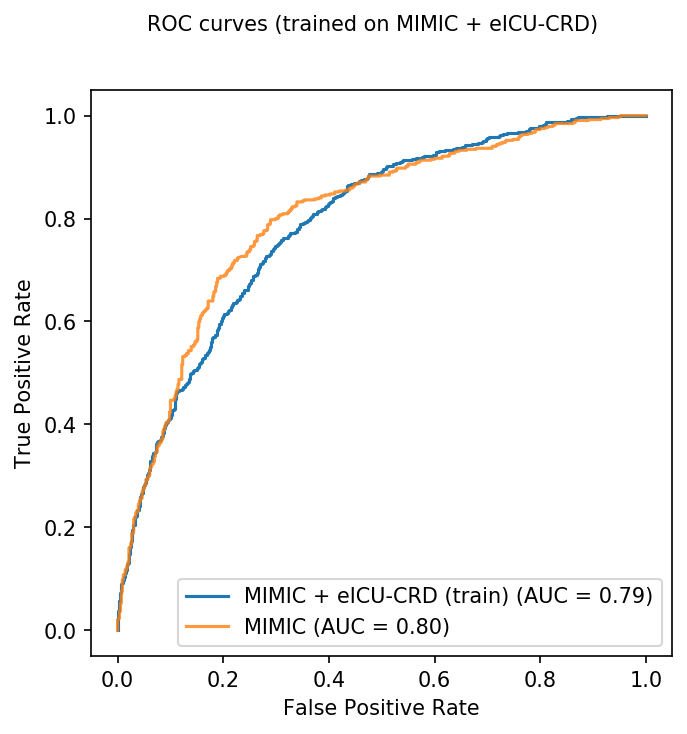

In [30]:
model.print_metrics(X_test_mimic,X_test_eICU,
                      y_test_mimic,y_test_eICU)

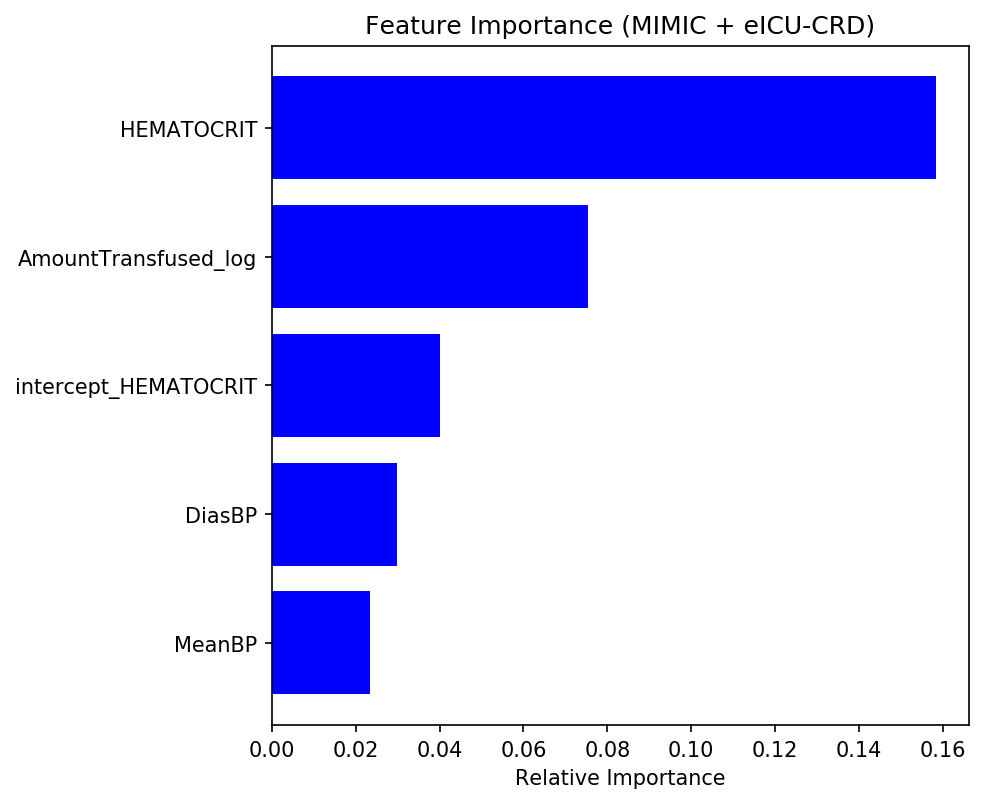

In [31]:
model.print_feature_importance(X_train,y_train)

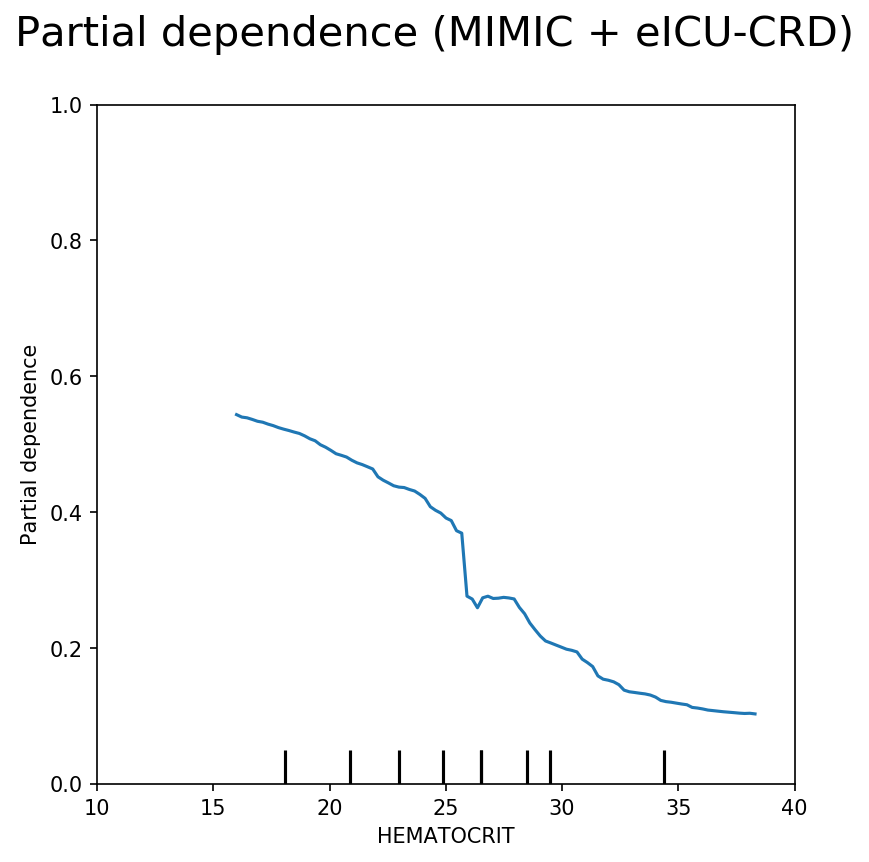

In [32]:
model.print_partial_dependence(X_train)

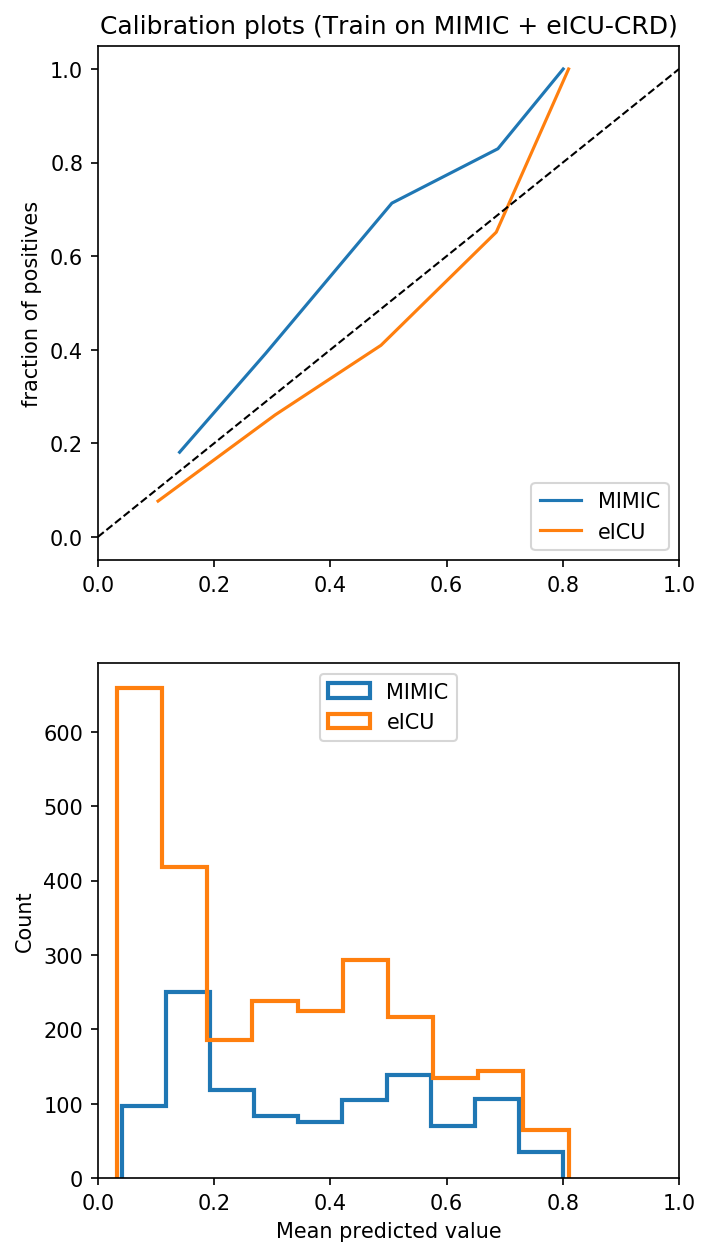

In [33]:
model.print_calibration_plot(X_test_mimic,y_test_mimic,X_test_eICU,y_test_eICU)

In [34]:
import pickle

with open(r"./Saved_iterations/05-24_trials_08acc_MIMIC_eICU", "wb") as output_file:     
        pickle.dump(trials, output_file)

with open(r"./Saved_iterations/05-24_names_08acc_MIMIC_eICU", "wb") as output_file:     
        pickle.dump(names, output_file)

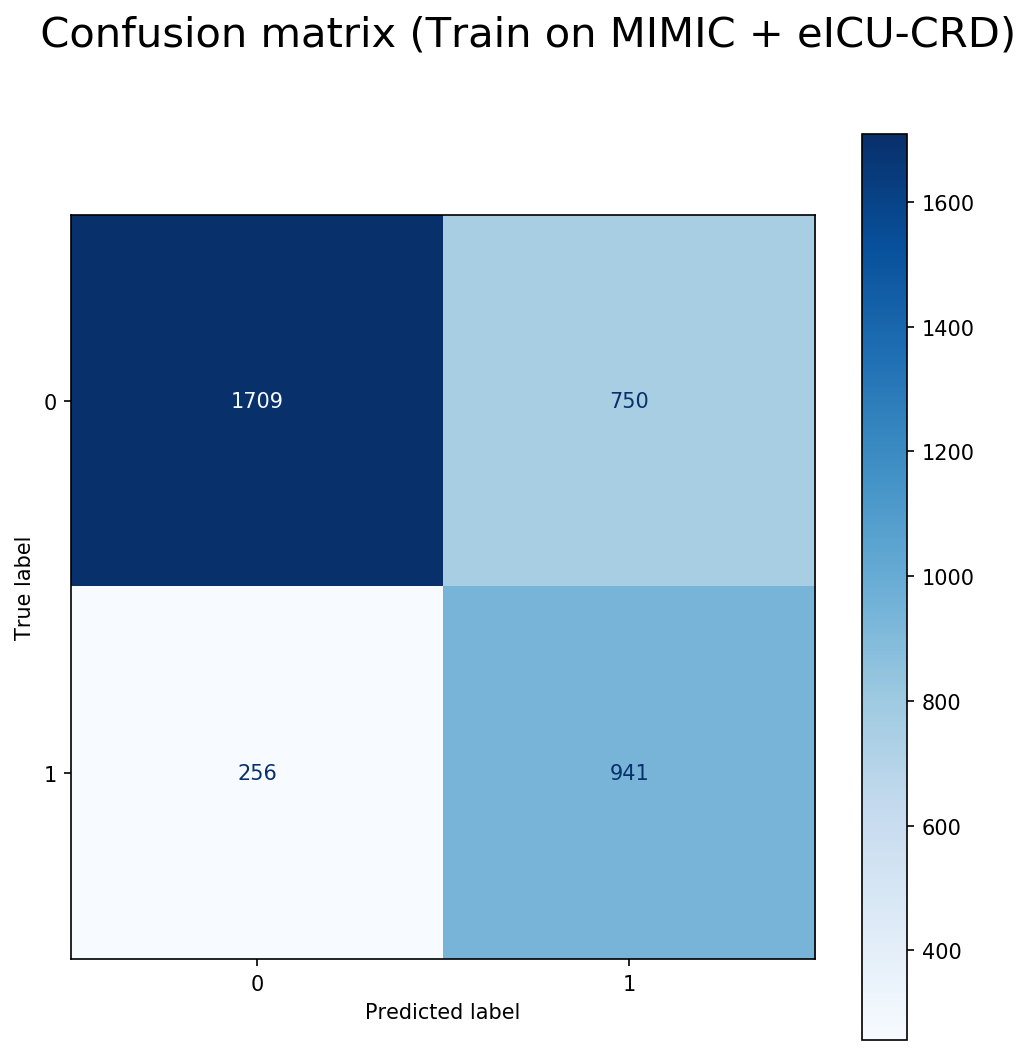

In [27]:
model.print_confusion_matrix(pd.concat([X_test_eICU,X_test_mimic]),pd.concat([y_test_eICU,y_test_mimic])['outcome'])